<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Setzungen unter beliebigen Lastfiguren

Eine Möglichkeit der Berechnung von Setzungen unter beliebigen Lastfiguren ist die Superposition der Boussinesq'schen Lösung vieler Einzelkräfte
$$
\Delta \sigma_{zz} = \frac{3F_z}{2\pi R^2} \frac{z^3}{R^3},
$$
die sich zur Gesamtlastfigur aufsummieren. Grundlage dafür ist die Linearität des Modells, die Superposition / Konvolution [1] erlaubt. Um Singularitätsprobleme mit der Boussinesq'schen Lösung zu vermeiden, wird alternativ die Rechtecklösung verwendet:

$$
    \Delta \sigma_{zz}(x,y,z) = \frac{q_0}{2\pi} \sum \limits_{i=0}^3 (-1)^i \left\{ \left[ \frac{1}{(x+x_i)^2 + z^2} + \frac{1}{(y+y_i)^2 + z^2} \right] \frac{(x+x_i)(y+y_i) z}{R_i} + \arctan \left[ \frac{(x+x_i)(y+y_i)}{z R_i} \right] \right\} \quad \text{mit} \quad R_i = \sqrt{(x+x_i)^2 + (y+y_i)^2 + z^2}
$$

Dabei sind die $x_i$ und $y_i$ die Eckpunkte des Fundaments mit den Abmessungen $(a \times b)$ in $x$ und $y$:

\begin{align}
    x_i &= \{-a/2,\ -a/2,\ a/2,\ a/2\} \quad \text{für } i \in [0,3]
    \\
    y_i &= \{-b/2,\ b/2,\ b/2,\ -b/2\} \quad \text{für } i \in [0,3]
\end{align}

[1] Nagel, T., Gerasimov, T., Remes, J., & Kern, D. (2025). Neighborhood Watch in Mechanics: Nonlocal Models and Convolution. SIAM Review, 67(1), 176–193. https://doi.org/10.1137/22M1541721

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # nötig für 3D
from concurrent.futures import ProcessPoolExecutor

In [2]:
# Parameter der Lastfläche
drand = 50.0
a, b = 600.0, 400.0

nx, ny = int(31*a/b), 31
dx = a / nx
dy = b / ny

# Anzahl zusätzlicher "Zellen" je Richtung, um drand abzudecken
mx = int(np.ceil(drand / dx))
my = int(np.ceil(drand / dy))

# Raster
x_centers = (np.arange(-mx, nx + mx) + 0.5) * dx
y_centers = (np.arange(-my, ny + my) + 0.5) * dy

#Achtung: Umdefinition
nx_tot = len(x_centers)
ny_tot = len(y_centers)

X, Y = np.meshgrid(x_centers, y_centers)

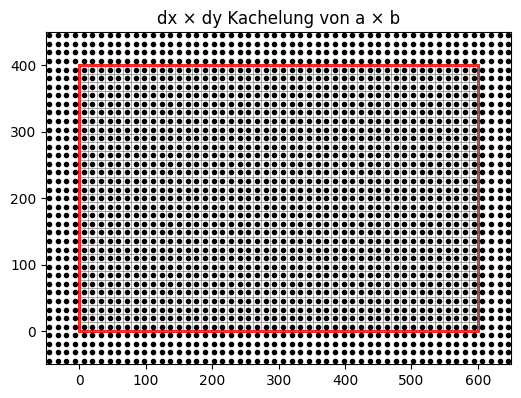

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))

# Punkte (Zentren)
ax.plot(X, Y, ls='', marker='.', color='k')

# Zellgrenzen im Innenbereich a x b
x_edges = np.linspace(0, a, nx + 1)
y_edges = np.linspace(0, b, ny + 1)

for xe in x_edges:
    ax.plot([xe, xe], [0, b], color='gray', lw=0.5)

for ye in y_edges:
    ax.plot([0, a], [ye, ye], color='gray', lw=0.5)

# Umrandung von a x b
ax.add_patch(plt.Rectangle((0, 0), a, b,
                           fill=False, edgecolor='red', lw=2))

ax.set_aspect('equal')
ax.set_xlim(-drand, a + drand)
ax.set_ylim(-drand, b + drand)
ax.set_title("dx × dy Kachelung von a × b")

plt.show()

In [4]:
# Flächenlastfunktion
# Kann auch Schichteneinteilung enthalten
#def f(x, y):
#        return 100 * (x / a ) * (1 - y / b) * np.heaviside(x,1) * np.heaviside(y,1) * np.heaviside(a-x,1) * np.heaviside(b-y,1)

def f(x, y):
    # Innenbereich mit maximaler Last
    a1 = 0.4 * a  # 40% von a
    b1 = 0.4 * b  # 40% von b
    x0 = a / 2
    y0 = b / 2

    # Abstand vom Mittelpunkt
    dx = np.abs(x - x0)
    dy = np.abs(y - y0)

    # Maximal erlaubte Halbausdehnung
    dx_max = a / 2
    dy_max = b / 2

    dx1 = a1 / 2
    dy1 = b1 / 2

    # Normierte Abstände (0 im Kern, 1 am Rand)
    nx = np.clip((dx - dx1) / (dx_max - dx1), 0, 1)
    ny = np.clip((dy - dy1) / (dy_max - dy1), 0, 1)

    # Last nimmt linear ab mit Entfernung von Zentrum
    load = 800 * (1 - np.maximum(nx, ny))

    # Bereich außerhalb des Rechtecks auf 0 setzen
    load *= np.heaviside(x, 1) * np.heaviside(y, 1) * np.heaviside(a - x, 1) * np.heaviside(b - y, 1)

    return load


Q = f(X, Y)

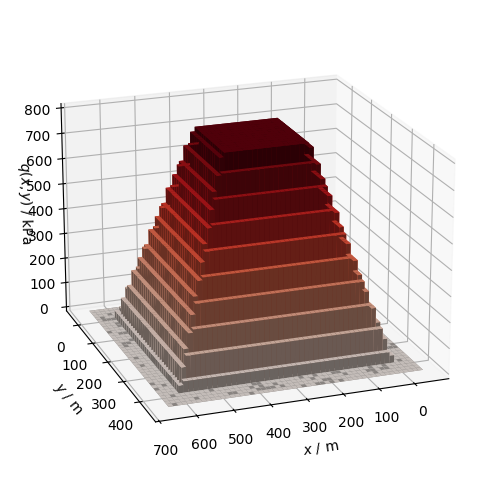

In [5]:
# Plot
from matplotlib.colors import Normalize
xpos = X.ravel()
ypos = Y.ravel()
Z = Q.ravel()
zpos = np.zeros_like(Z)  # bars start at z = 0

# Color mapping based on Z values
norm = Normalize(vmin=Z.min(), vmax=Z.max())
colors = plt.cm.Reds(norm(Z))

# Plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# 3D bar plot
ax.bar3d(xpos, ypos, zpos, dx, dy, Z, shade=True, color=colors)
ax.view_init(elev=20, azim=70)  # change view angle if needed

# Achsenbeschriftungcmap
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_zlabel(r'$q(x,y)$ / kPa',labelpad=-2)
fig.tight_layout();
#fig.savefig('load_pyramid.pdf')

In [6]:
# Steifemodul als Funktion der Tiefe
def E_z(z):
    return 13000 + 4000 * np.sqrt(z)

In [7]:
def sigma_z_rectangle(x, y, z, q0, a, b, z_eps=1e-9):
    z = np.maximum(z, z_eps)

    # Ecken relativ zum Rechteckzentrum
    xi = np.array([-a/2, -a/2,  a/2,  a/2])[:, None, None]   # (4,1,1)
    yi = np.array([-b/2,  b/2,  b/2, -b/2])[:, None, None]   # (4,1,1)
    sign = np.array([1, -1, 1, -1])[:, None, None]           # (4,1,1)

    # x,y in 2D-Form bringen (ohne Kopie, falls schon 2D)
    X = np.asarray(x)[None, ...]  # (1,ny,nx) oder (1,...) broadcastbar
    Y = np.asarray(y)[None, ...]
    Q0 = np.asarray(q0)[None, ...]

    Xc = X + xi
    Yc = Y + yi

    R = np.sqrt(Xc**2 + Yc**2 + z**2)

    term1 = (Xc * Yc * z / R) * (1.0/(Xc**2 + z**2) + 1.0/(Yc**2 + z**2))
    term2 = np.arctan2(Xc * Yc, R * z)

    sigma = (Q0 / (2*np.pi)) * np.sum(sign * (term1 + term2), axis=0)
    return sigma

In [8]:
def compute_point_rect(ix, jy, Xc, Yc, z_layers, dz, x_centers, y_centers, Q, dx, dy):
    x_obs = x_centers[ix]
    y_obs = y_centers[jy]
    s_total = 0.0

    # Einmal pro Beobachtungspunkt: relative Koordinaten aller Zellzentren
    # Form: (ny, nx)
    x_rel = x_obs - Xc
    y_rel = y_obs - Yc

    for z in z_layers:
        z_eff = z + dz/2

        # sigma_z-Beitrag aller Zellen in einem Rutsch
        sigma_grid = sigma_z_rectangle(x_rel, y_rel, z_eff, Q, dx, dy)

        # Gesamtspannung am Beobachtungspunkt
        delta_sigma = np.sum(sigma_grid)

        E = E_z(z_eff)
        s_total += (delta_sigma / E) * dz

    return jy, ix, s_total


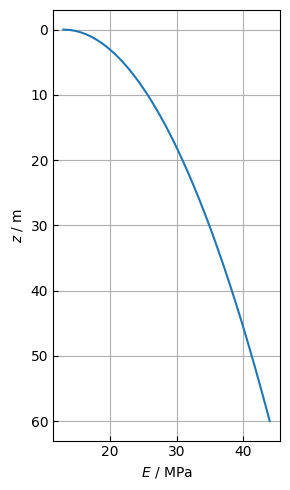

In [9]:
fig, ax = plt.subplots(figsize=(3,5))
z_layers = np.linspace(0, 60, 1000)
ax.plot(E_z(z_layers)/1e3,z_layers)
ax.invert_yaxis()
ax.grid(True)
ax.tick_params(direction='in')
ax.set_xlabel('$E$ / MPa')
ax.set_ylabel('$z$ / m')
fig.tight_layout();

In [10]:
# Wrapper zur parallelen Berechnung
def compute_settlement_parallel(z_max=10.0, nz=40):
    z_layers = np.linspace(0, z_max, nz+1)[:-1]

    dz = z_layers[1] - z_layers[0]
    settlement = np.zeros((ny_tot, nx_tot))

    Xc, Yc = np.meshgrid(x_centers, y_centers)   # default indexing='xy' -> passt zu Q[j,i]
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_point_rect, ix, jy, Xc, Yc, z_layers, dz, x_centers, y_centers, Q, dx, dy)
                   for jy in range(ny_tot) for ix in range(nx_tot)]
        for future in futures:
            jy, ix, s_val = future.result()
            settlement[jy, ix] = s_val

    return settlement

In [11]:
settlement = compute_settlement_parallel(z_max=60.0,nz=20)

## Berechnung mit direkter Methode

Aufgrund des Superpositionsprinzips kann die Boussinesq-Lösung u.a. so integriert werden, dass die Eckpunktsetzungen einer $a \times b$ großen Rechtecklast der Intensität $q_0$ ermittelt werden können. Führt man die Integration des Vertikaldehnungsfeldes in den veränderten Grenzen 

$$
    s = \int \limits_{z=0}^{z=t} \epsilon_{zz} \text{d}z
$$

aus, also bis in eine endliche Tiefe $t$ durch, so entspricht das einer in der Tiefe $t$ anstehenden undeformierbaren Baugrundschicht. Die Eckpunktsetzung ergibt sich zu

$$
    s = \frac{q_0 (1-\nu^2)}{\pi E} \left[
        a \ln \frac{\left( b + \sqrt{a^2 + b^2} \right) \sqrt{a^2 + t^2}}{a(b+R)} + 
        b \ln \frac{\left( a + \sqrt{a^2 + b^2} \right) \sqrt{b^2 + t^2}}{b(a+R)}
    \right] + 
    \frac{q_0 (1-\nu-2\nu^2)}{2 \pi E} t \arctan \left( \frac{ab}{tR} \right)
$$

mit $R = \sqrt{a^2 + b^2 + t^2}$.

Die diskrete Lastfläche wird über Superposition belasteter und unbelasteter Flächenelemente integriert.

Tiefenabhängige Steifemoduln werden wie folgt einbezogen:

<img src="https://github.com/nagelt/Teaching_Scripts/raw/master/Images/settlement_layers.png" style="width: 1200px;"/>

In [12]:
def s3D_Rechteck_signed(t, a, b, E, nu, q0, eps=1e-12):
    aa = np.maximum(np.abs(a), eps)
    bb = np.maximum(np.abs(b), eps)

    Rad = np.sqrt(aa**2 + bb**2 + t**2)

    fak1 = q0*(1-nu**2)/(np.pi * E)
    fak2 = q0*(1-nu-2*nu**2)/(2*np.pi * E)

    # WICHTIG: Vorfaktoren a bzw. b (nicht aa/bb)
    t1 = a*np.log(((bb + np.sqrt(aa**2+bb**2)) * np.sqrt(aa**2+t**2)) / (aa*(bb+Rad)))
    t2 = b*np.log(((aa + np.sqrt(aa**2+bb**2)) * np.sqrt(bb**2+t**2)) / (bb*(aa+Rad)))

    # WICHTIG: a*b (nicht aa*bb)
    t3 = t * np.arctan2(a*b, t*Rad)

    return fak1 * (t1 + t2) + fak2 * t3

In [17]:
def u_rect_at_depth(t, x_obs, y_obs, Xc, Yc, q, dx, dy, E_oed, nu_def, eps=1e-12):
    xL = Xc - dx/2
    xR = Xc + dx/2
    yB = Yc - dy/2
    yT = Yc + dy/2

    AL = x_obs - xL
    AR = xR - x_obs
    BB = y_obs - yB
    BT = yT - y_obs

    def sgn(v):
        return np.where(v >= 0.0, 1.0, -1.0)

    U = s3D_Rechteck_signed 

    #mask_origin = (np.abs(Xc) <= dx/3) & (np.abs(Yc) <= dy/3)
    #nu = np.where(mask_origin, 0.0, nu_def)
    nu = nu_def
    E = E_oed * (1 + nu) * (1 - 2*nu) / (1 - nu)

    #Vorzeichenwechsel zur Unterscheidung von inneren und äußeren Punkten (in Bezug auf Kacheln)
    return (
        sgn(AL)*sgn(BB) * U(t, np.maximum(np.abs(AL), eps), np.maximum(np.abs(BB), eps), E, nu, q)
      + sgn(AR)*sgn(BB) * U(t, np.maximum(np.abs(AR), eps), np.maximum(np.abs(BB), eps), E, nu, q)
      + sgn(AL)*sgn(BT) * U(t, np.maximum(np.abs(AL), eps), np.maximum(np.abs(BT), eps), E, nu, q)
      + sgn(AR)*sgn(BT) * U(t, np.maximum(np.abs(AR), eps), np.maximum(np.abs(BT), eps), E, nu, q)
    )

In [18]:
def compute_point_rect_direct(ix, jy, Xc, Yc, z_layers, dz, x_centers, y_centers, Q, dx, dy, nu=0.3):
    x_obs = x_centers[ix]
    y_obs = y_centers[jy]
    s_total = 0.0

    for z in z_layers:
        z_top = np.maximum(z, 1e-6)
        z_bot = z + dz
        z_mid = z + dz/2

        #sigma_grid = sigma_z_rectangle(x_rel, y_rel, z_mid, Q, dx, dy)

        # Gesamtspannung am Beobachtungspunkt
        #delta_sigma = np.sum(sigma_grid)

        E_oed = E_z(z_mid)#*0.88

        # Verschiebung u(z) aus allen Zellen (Superposition)
        u_top = u_rect_at_depth(z_top, x_obs, y_obs, Xc, Yc, Q, dx, dy, E_oed, nu)
        u_bot = u_rect_at_depth(z_bot, x_obs, y_obs, Xc, Yc, Q, dx, dy, E_oed, nu)

        # Schichtkompression ~ u(z_top) - u(z_bot)
        s_total -= np.sum(u_top - u_bot)

    return jy, ix, s_total

In [19]:
# Wrapper zur parallelen Berechnung
def compute_settlement_parallel_direct(z_max=10.0, nz=40):
    z_layers = np.linspace(0, z_max, nz+1)[:-1]

    dz = z_layers[1] - z_layers[0]
    settlement = np.zeros((ny_tot, nx_tot))

    # Zellzentren als 2D-Felder passend zu Q[j,i]
    Xc, Yc = np.meshgrid(x_centers, y_centers, indexing='xy')

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_point_rect_direct, ix, jy, Xc, Yc, z_layers, dz, x_centers, y_centers, Q, dx, dy)
                   for jy in range(ny_tot) for ix in range(nx_tot)]
        for future in futures:
            jy, ix, s_val = future.result()
            settlement[jy, ix] = s_val

    return settlement

In [20]:
settlement_direct = compute_settlement_parallel_direct(z_max=60.0,nz=20)

NameError: name 'slope_to_center_1pct_on_load' is not defined

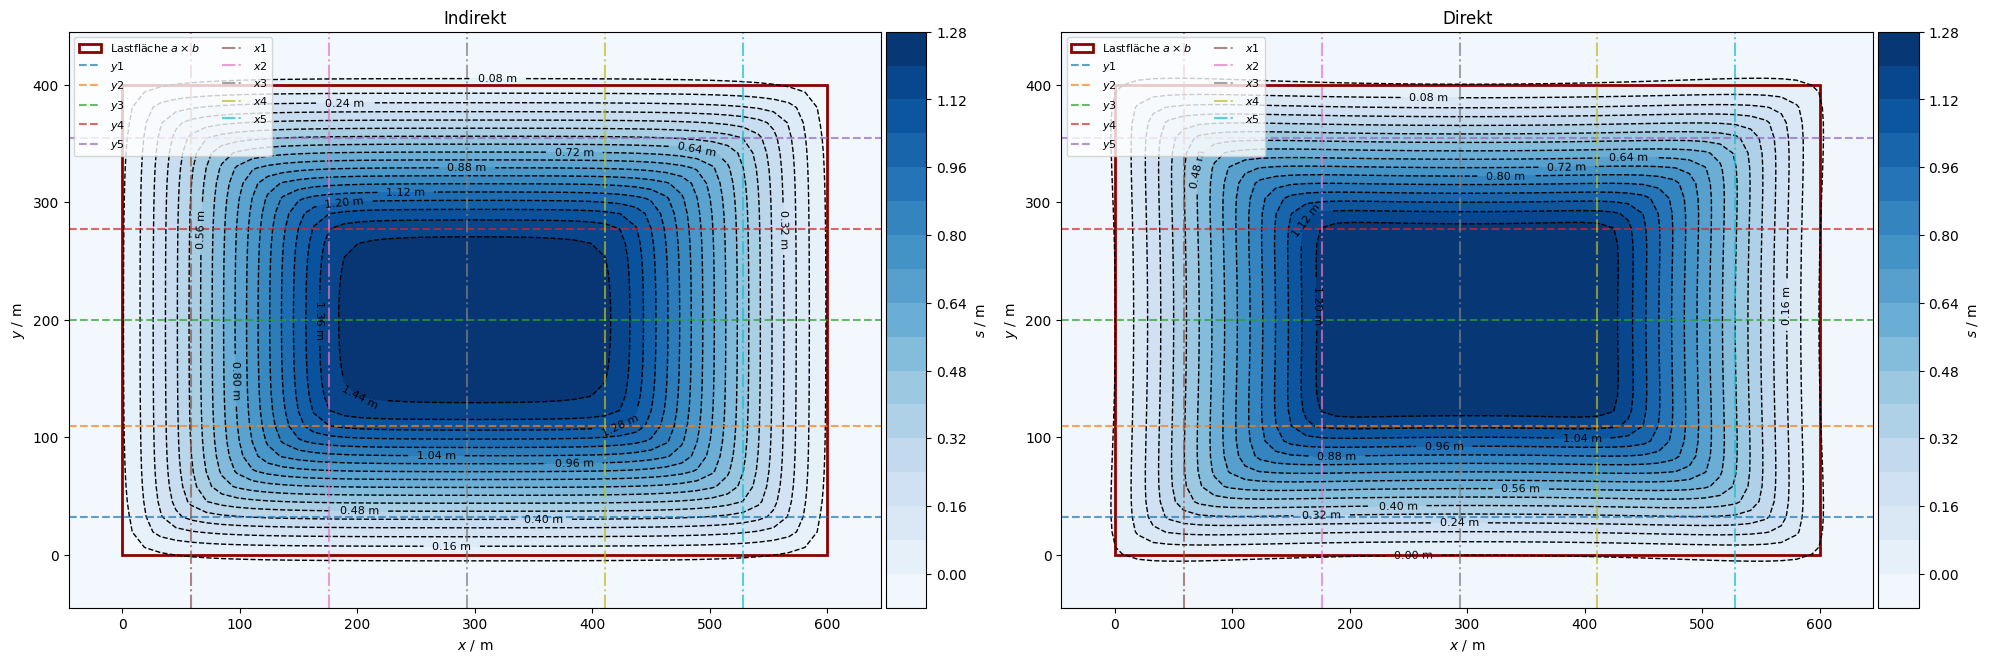

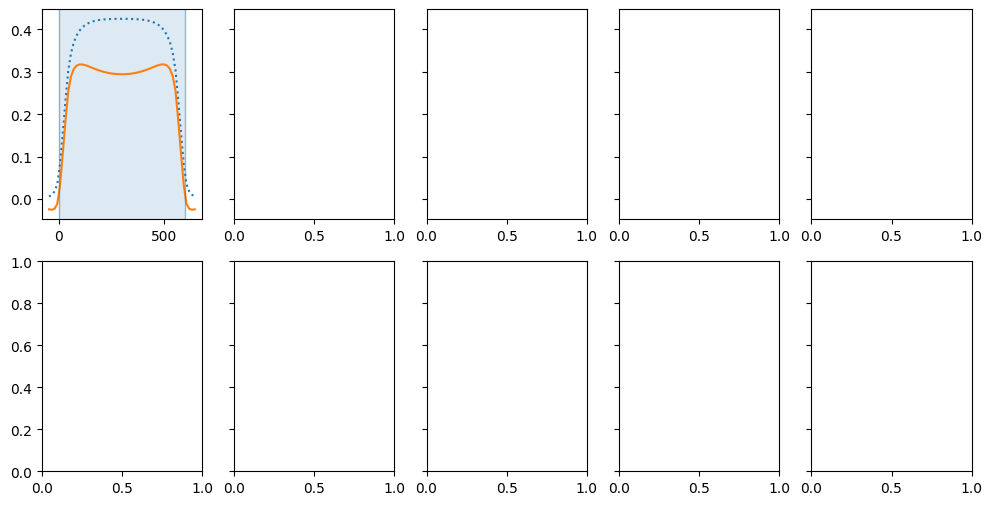

In [22]:
n_profiles = 7
ix_profiles = np.linspace(0, X.shape[1] - 1, n_profiles, dtype=int)
iy_profiles = np.linspace(0, Y.shape[0] - 1, n_profiles, dtype=int)

# nur mittlere Profile
ix_mid = ix_profiles[1:-1]
iy_mid = iy_profiles[1:-1]

def slope_to_center_1pct_on_load(u, u0, u1):
    
    u = np.asarray(u, dtype=float)

    u_center = 0.5 * (u0 + u1)
    half_width = 0.5 * (u1 - u0)

    s_ref = np.full_like(u, np.nan, dtype=float)
    inside = (u >= u0) & (u <= u1)

    # "Dachlinie": 0 an den Rändern, Maximum in der Mitte
    s_ref[inside] = 0.01 * (half_width - np.abs(u[inside] - u_center))

    return s_ref
# =======================
# (A) 2D-Konturplot + Profile
# =======================
settlement_plot = settlement  # in m
settlement_plot_d = settlement_direct

fig, ax = plt.subplots(figsize=(20, 7),ncols=2)

c1 = ax[0].contourf(X, Y, settlement_plot, levels=20, cmap='Blues')
c2 = ax[0].contour(X, Y, settlement_plot, levels=20,
                colors='black', linewidths=1, linestyles='--')
ax[0].clabel(c2, inline=True, fontsize=8, fmt='%1.2f m')
ax[0].set_title('Indirekt')

c1 = ax[1].contourf(X, Y, settlement_plot_d, levels=20, cmap='Blues')
c2 = ax[1].contour(X, Y, settlement_plot_d, levels=20,
                colors='black', linewidths=1, linestyles='--')
ax[1].clabel(c2, inline=True, fontsize=8, fmt='%1.2f m')
ax[1].set_title('Direkt')

for i in range(2):
# Lastfläche
    rect = patches.Rectangle((0, 0), a, b,
                             linewidth=2, edgecolor='darkred',
                             facecolor='none', label=r'Lastfläche $a \times b$')
    ax[i].add_patch(rect)
    
    # y-Profile (horizontal) – nur mittlere
    for k, iy in enumerate(iy_mid, start=1):
        ax[i].plot(X[iy, :], Y[iy, :],
                linestyle='--', linewidth=1.5, alpha=0.7,
                label=f'$y{k}$')
    
    # x-Profile (vertikal) – nur mittlere
    for k, ix in enumerate(ix_mid, start=1):
        ax[i].plot(X[:, ix], Y[:, ix],
                linestyle='-.', linewidth=1.5, alpha=0.7,
                label=f'$x{k}$')
    
    # Colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(c1, cax=cax, label='$s$ / m')
    
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$y$ / m')
    ax[i].set_aspect('equal')
    ax[i].legend(loc='upper left', ncol=2, fontsize=8, frameon=True)
    fig.tight_layout()

# =======================
# (B) Profile: 2 x 3 Subplots
# =======================
fig2, axes = plt.subplots(2, len(ix_mid), figsize=(12, 6), sharey='row')

# ---- obere Reihe: s(x) bei festem y
for k, iy in enumerate(iy_mid, start=1):
    axp = axes[0, k-1]
    x_line = X[iy, :]
    s_line = settlement[iy, :]
    s_d_line = settlement_direct[iy, :]

    axp.plot(x_line, s_line, label='Setzung, indirekt',ls=':')
    axp.plot(x_line, s_d_line, label='Setzung, direkt')

    # Lastfläche als Band (x von 0 bis a)
    axp.axvspan(0, a, alpha=0.15, label='Lastfläche' if k == 1 else None)
    axp.axvline(0, linewidth=1, alpha=0.5)
    axp.axvline(a, linewidth=1, alpha=0.5)

    # 1% Neigung zur Mitte – NUR auf [0, a]
    s_ref = slope_to_center_1pct_on_load(x_line, 0.0, a)
    axp.plot(x_line, s_ref, linestyle=':', linewidth=1.5,
             label='1% Neigung → Mitte' if k == 1 else None)

    axp.set_title(f'$y{k}:\\; y = {Y[iy, 0]:.1f}\\,$m')
    axp.set_xlabel('$x$ / m')
    if k == 1:
        axp.set_ylabel('$s$ / m')
    axp.grid(True)
    axp.invert_yaxis()

# ---- untere Reihe: s(y) bei festem x
for k, ix in enumerate(ix_mid, start=1):
    axp = axes[1, k-1]
    y_line = Y[:, ix]
    s_line = settlement[:, ix]
    s_d_line = settlement_direct[:, ix]

    axp.plot(y_line, s_line, label='Setzung, indirekt',ls=':')
    axp.plot(y_line, s_d_line, label='Setzung, direkt')

    # Lastfläche als Band (y von 0 bis b)
    axp.axvspan(0, b, alpha=0.15, label='Lastfläche' if k == 1 else None)
    axp.axvline(0, linewidth=1, alpha=0.5)
    axp.axvline(b, linewidth=1, alpha=0.5)

    # 1% Neigung zur Mitte – NUR auf [0, b]
    s_ref = slope_to_center_1pct_on_load(y_line, 0.0, b)
    axp.plot(y_line, s_ref, linestyle=':', linewidth=1.5,
             label='1% Neigung → Mitte' if k == 1 else None)

    axp.set_title(f'$x{k}:\\; x = {X[0, ix]:.1f}\\,$m')
    axp.set_xlabel('$y$ / m')
    if k == 1:
        axp.set_ylabel('$s$ / m')
    axp.grid(True)
    axp.invert_yaxis()

# Legend nur einmal – sammelt die "einmaligen" Labels
#handles, labels = axes[0, 0].get_legend_handles_labels()
#if handles:
#    fig2.legend(handles, labels, loc='lower center', ncol=3, frameon=True)

fig2.suptitle('Setzungsprofile in x- und y-Richtung', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()